![display relevant image here](path/url/to/image)
- Banner/header image

# Title
- Relevant to Data and Business Context

## Overview
- BLUF (Bottom Line Up Front)
- One paragraph summary of final model performance and business implications
- Frame your 'story'

## Business Understanding

### Primary Objectives:
- Develop a model to predict loan default risk scores to support human-in-the-loop loan decisions
- Ensure the model prioritizes predictive power, fairness, and business alignment


### Selected Evaluation Metrics:
- Mean Squared Error (MSE) or Root Mean Squared Error (RMSE)
    - Measures how close the model's risk predictions are to actual observed outcomes. This is useful for penalizing large errors. 
- Area Under the ROC Curve (AUC-ROC)
    - Even though we’re using regression, we can convert the output to binary labels (default vs. non-default) for evaluation. This assesses the model’s ability to discriminate between high and low risk, which is crucial for prioritization


### Profit-adjusted cost function
- Incorporate business impact into the metric, such as:
    - Profit = (Interest earned from good loans) – (Losses from default) – (Cost of missed opportunities)


### Baseline Targets:
- RMSE no worse than the average error of loan officers' historical decisions (established via internal benchmark)
- AUC > 0.75 for acceptable discrimination
- Improvement in overall loan portfolio performance (measured by ROI or default rate) within 6–12 months


### Model Design Notes:
- Initial candidate model: XGBoost Regressor, I chose this for its ability to handle feature interactions and missing values


### Key predictive features: credit score, debt-to-income ratio, employment length, and credit history


### Human-centered impact: 
- Slightly boost predicted approval scores for applicants with socially relevant needs, such as medical loans, education funding, or first-time home buyers, to reflect company values and goodwill considerations (handled via feature engineering)




## Data Understanding
3. Conduct comprehensive exploratory data analysis:
- Describe basic data characteristics
- Examine distributions of all features and target variables
- Investigate relationships between features
- Create visualizations to help aid in EDA
- Document potential data quality issues and their implications

4. Develop feature understanding:
- Categorize features by type (numerical, categorical, ordinal)
- Identify features requiring special preprocessing
- Document missing value patterns and their potential meanings
- Note potential feature engineering opportunities


In [1]:
# Data manipulation & visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipeline tools
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Model selection & evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score


# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


Shape of dataset: (20000, 35)

Missing values:
CreditScore             0
LoanAmount              0
DebtToIncomeRatio       0
MonthlyIncome           0
EmploymentStatus        0
EducationLevel        901
MaritalStatus        1331
LoanPurpose             0
dtype: int64

Data types:
CreditScore            int64
LoanAmount             int64
DebtToIncomeRatio    float64
MonthlyIncome        float64
EmploymentStatus      object
EducationLevel        object
MaritalStatus         object
LoanPurpose           object
dtype: object


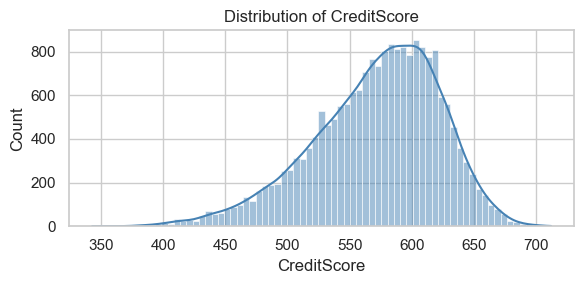

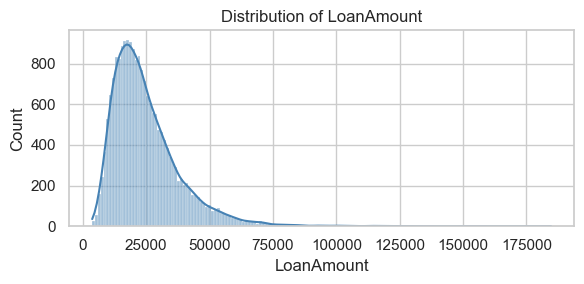

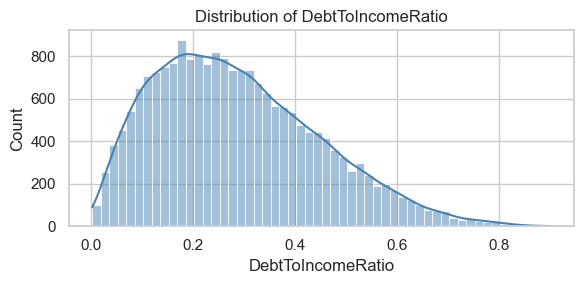

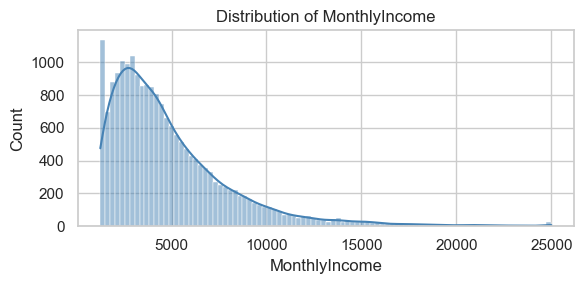

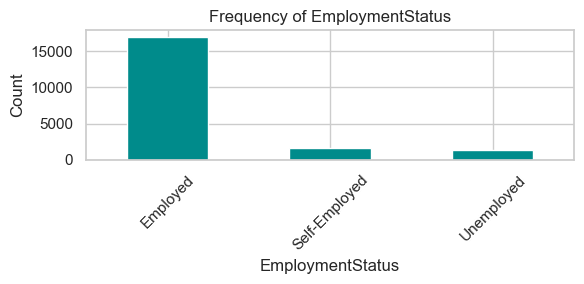

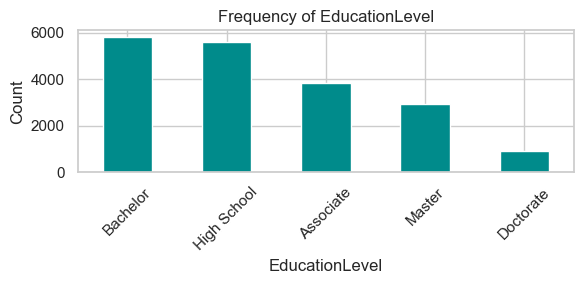

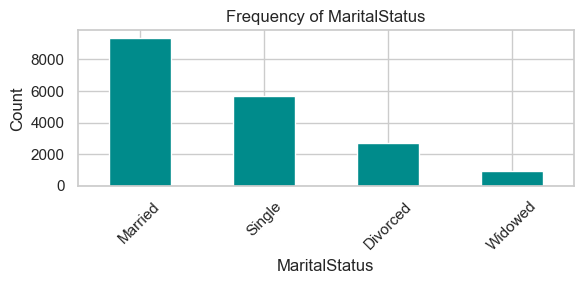

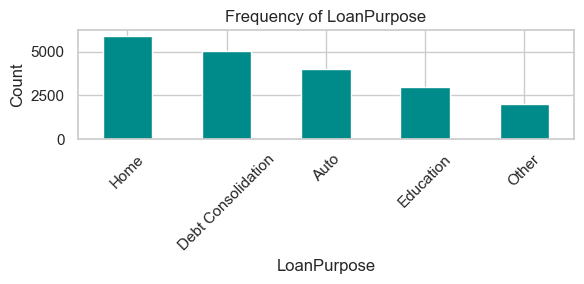

In [2]:

# Load the dataset
df = pd.read_csv("Financial Loan Data.csv")  # Adjust path if needed

# Set visualization style
sns.set(style="whitegrid")

# Focused columns for EDA
key_numerical = ['CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'MonthlyIncome']
key_categorical = ['EmploymentStatus', 'EducationLevel', 'MaritalStatus', 'LoanPurpose']

# 1. Basic Info
print("Shape of dataset:", df.shape)
print("\nMissing values:")
print(df[key_numerical + key_categorical].isnull().sum())
print("\nData types:")
print(df[key_numerical + key_categorical].dtypes)

# 2. Distribution plots for numerical features
for col in key_numerical:
    plt.figure(figsize=(6, 3))
    sns.histplot(df[col].dropna(), kde=True, color='steelblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# 3. Count plots for categorical features
for col in key_categorical:
    plt.figure(figsize=(6, 3))
    df[col].value_counts().plot(kind='bar', color='darkcyan')
    plt.title(f'Frequency of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## Data Preparation
5. Design your preprocessing strategy:
- Create separate preprocessing flows for different feature types
- Must utilize ColumnTransformer and Pipeline
- Consider using FeatureUnion as well
- Handle missing values appropriately for each feature
- Handle Categorical and Ordinal data appropriately
- Scale numeric values if model requires it (linear model)
- Document your reasoning for each preprocessing decision



In [8]:
# Data Prep Code Here - Create New Cells As Needed
numerical_features = ['CreditScore', 'LoanAmount', 'DebtToIncomeRatio', 'MonthlyIncome']
categorical_features = ['EmploymentStatus', 'MaritalStatus', 'LoanPurpose']
ordinal_features = ['EducationLevel']  # assuming order: High School < College < Bachelor < Master < Doctorate

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

education_order = [['High School', 'Associate', 'Bachelor', 'Master', 'Doctorate']]
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal_encoder', OrdinalEncoder(categories=education_order))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features),
    ('ord', ordinal_transformer, ordinal_features)
])

### Reasoning for preprocessing decisions:
- Numerical: Used median since it's helpful with outliers and scaling.
- Categorical: I wanted to ensure there were consistent categories. Also with, one-hot encoding it minimizes assumptions.
- Ordinal: Maintained order using OrdinalEncoder, assuming a progression in education level.
- ColumnTransformer: Ensures separate logic per feature type, all bundled into a pipeline-ready object.

## Modeling
6. Implement your modeling approach:
- Choose appropriate model algorithms based on your problem definition
- Set up validation strategy with chosen metrics
- Use a train test split and cross validation
- Create complete pipeline including any preprocessing and model
- Document your reasoning for each modeling decision

In [9]:
#  Modeling Code Here - Create New Cells as Needed
# Assuming 'df' is your cleaned DataFrame and 'LoanApproved' is your target
X = df.drop(columns=['LoanApproved'])
y = df['LoanApproved']



7. Optimize your model:
- Define parameter grid based on your understanding of the algorithms
- Implement GridSearchCV and/or RandomizedSearchCV with chosen metrics
- Consider tuning preprocessing steps
- Track and document the impact of different parameter combinations
- Consider the trade-offs between different model configurations

NOTE: Be mindful of time considerations - showcase “how to tune” 

In [10]:
# Train/test split (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Attach model to the preprocessor
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # from earlier step
    ('classifier', RandomForestClassifier(random_state=42))
])

In [11]:
# Define scoring metrics to evaluate
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall'
}
rf_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5],
    'classifier__class_weight': ['balanced', None]
}
rf_grid_search = GridSearchCV(
    rf_pipeline,
    param_grid=rf_param_grid,
    cv=5,
    scoring='f1',  # you can change this to recall or f1
    refit=True,
    return_train_score=True
)

rf_grid_search.fit(X_train, y_train)
best_model = rf_grid_search.best_estimator_

In [12]:
# Predict on test set
y_pred = best_model.predict(X_test)

# Print evaluation results
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8558
Precision: 0.6610054347826086
Recall: 0.8142259414225942

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      3805
           1       0.66      0.81      0.73      1195

    accuracy                           0.86      5000
   macro avg       0.80      0.84      0.82      5000
weighted avg       0.87      0.86      0.86      5000



## Evaluation and Conclusion
8. Conduct thorough evaluation of final model:
- Assess models test data performance using your defined metrics
- Analyze performance across different data segments
- Identify potential biases or limitations
- Visualize model performance
    - Classification: Confusion Matrix/ROC-AUC
    - Regression: Scatter Plot (Predicted vs. Actual values)

9. Extract and interpret feature importance/significance:
- Which features had the most impact on your model?
- Does this lead to any potential business recommendations?

10. Prepare your final deliverable:
- Technical notebook with complete analysis
- Executive summary for business stakeholders
- Recommendations for implementation
- Documentation of potential improvements

In [13]:
# Evaluation and Conclusion
final_model = best_model

# 1. Final predictions
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1] 

# 2. Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.87      0.90      3805
           1       0.66      0.81      0.73      1195

    accuracy                           0.86      5000
   macro avg       0.80      0.84      0.82      5000
weighted avg       0.87      0.86      0.86      5000

ROC-AUC Score: 0.9223982977693962


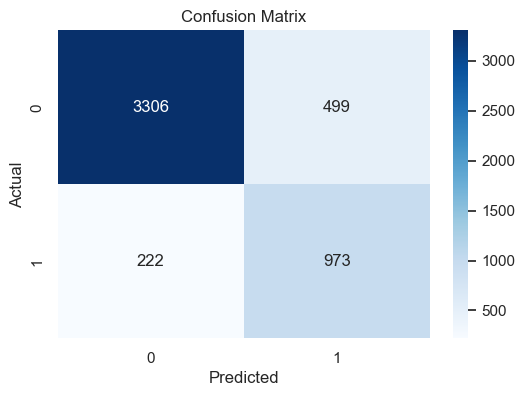

In [14]:
# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

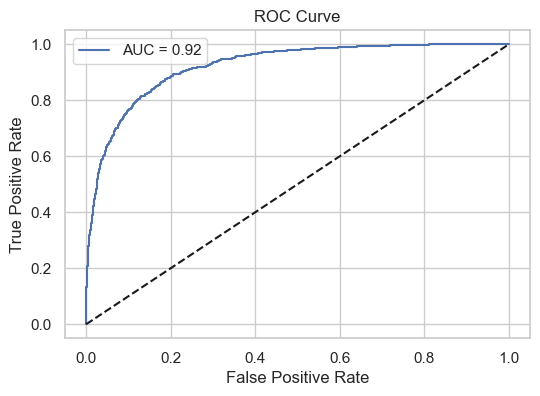

In [15]:
# 4. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

/var/folders/p6/qb4n9cmd63vczr6sz1cp91z00000gn/T/ipykernel_74359/152788085.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')


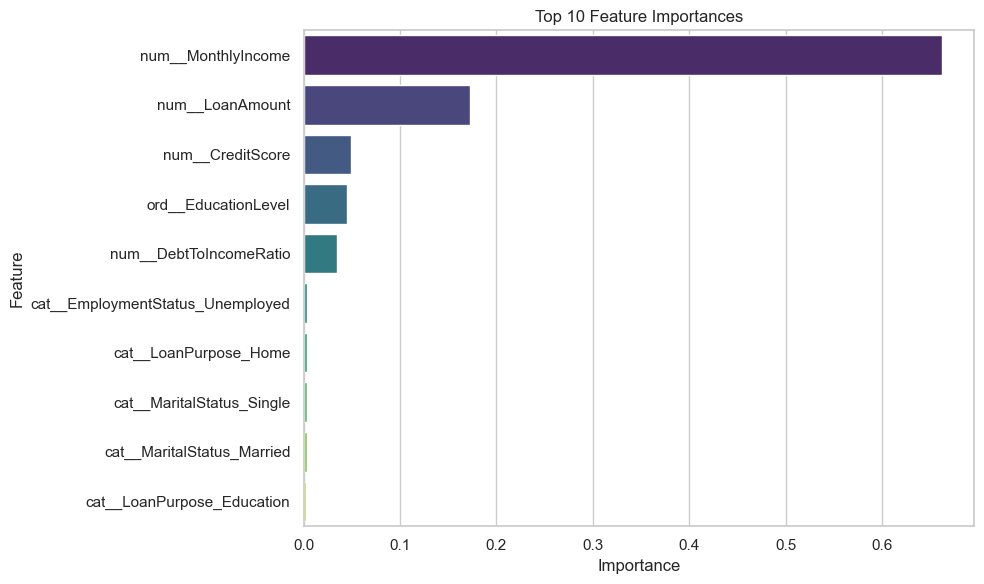

In [16]:
# 5. Feature Importance (for XGBoost or tree-based models)
importances = final_model.named_steps['classifier'].feature_importances_
feature_names = final_model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature', palette='viridis')
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()

#with an extra day I'd give it more love, but givin the circumstances I don't want to fall behind.

<!-- # 6. Business Recommendations (documented in markdown or notebook cells)
# - Identify features that have strong predictive power (e.g. CreditScore, DebtToIncomeRatio)
# - Recommend operational changes or policy tweaks for features like EducationLevel or EmploymentStatus
# - Suggest additional data collection if high-impact features are missing or incomplete

# 7. Final Deliverables
# - Ensure your notebook includes:
#   • Clear section headings (e.g., EDA, Modeling, Evaluation)
#   • Well-commented code
#   • Visuals for performance interpretation
#   • Summary markdown cells with business insights and model limitations

# - Executive Summary (in markdown or separate PDF):
#   • What was the goal?
#   • What was the best model?
#   • How well did it perform?
#   • What should the business do next? -->